In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [4]:
# !pwd

### Data Description

Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

In [5]:
telemetry_raw = pd.read_csv("Data/PdM_telemetry.csv")
errors_raw = pd.read_csv("Data/PdM_errors.csv")
maintenance_raw = pd.read_csv("Data/PdM_maint.csv")
failures_raw = pd.read_csv("Data/PdM_failures.csv")
metadata_raw = pd.read_csv("Data/PdM_machines.csv")

datasets = {"telemetry": telemetry_raw, "errors": errors_raw, "maintenance": maintenance_raw, "failures": failures_raw, "metadata": metadata_raw}

### Exploratory Data Analysis

In [6]:
for k,v in datasets.items():
    print(f"Size of {k} dataset:", v.shape)

Size of telemetry dataset: (876100, 6)
Size of errors dataset: (3919, 3)
Size of maintenance dataset: (3286, 3)
Size of failures dataset: (761, 3)
Size of metadata dataset: (100, 3)


In [7]:
telemetry_raw.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [8]:
metadata_raw.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [9]:
# Makes sense to add machine metadata alongside machine telemetry to act as predictors

feature_df = pd.merge(telemetry_raw, metadata_raw, on="machineID", how = "outer")
assert feature_df.shape[0] == telemetry_raw.shape[0]
feature_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18


In [10]:
print(f"The first and last datetime for telemetry observations are {feature_df['datetime'].sort_values().min()} and {feature_df['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for error observations are {errors_raw['datetime'].sort_values().min()} and {errors_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for failure observations are {failures_raw['datetime'].sort_values().min()} and {failures_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for maintenance observations are {maintenance_raw['datetime'].sort_values().min()} and {maintenance_raw['datetime'].sort_values().max()} respectively")

The first and last datetime for telemetry observations are 2015-01-01 06:00:00 and 2016-01-01 06:00:00 respectively
The first and last datetime for error observations are 2015-01-01 06:00:00 and 2016-01-01 05:00:00 respectively
The first and last datetime for failure observations are 2015-01-02 03:00:00 and 2015-12-31 06:00:00 respectively
The first and last datetime for maintenance observations are 2014-06-01 06:00:00 and 2016-01-01 06:00:00 respectively


In [11]:
errors_raw.head() # 3919

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [12]:
failures_raw.head() # 761

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [13]:
failures_raw['time'] = failures_raw['datetime'].apply(lambda x: x.split(" ")[1])
failures_raw["time"].unique()

# All failures are recorded either at 0600 hrs or 0300 hrs

array(['06:00:00', '03:00:00'], dtype=object)

In [14]:
maintenance_raw.head() # 3286

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [15]:
maintenance_raw['time'] = maintenance_raw['datetime'].apply(lambda x: x.split(" ")[1])
maintenance_raw["time"].unique()

# Most maintenance happens around 0600 hrs

array(['06:00:00'], dtype=object)

In [16]:
is_subset = failures_raw.isin(maintenance_raw).all().all()
print(is_subset)

# confirming if any failures are present in maintenance dataset at all or no

False


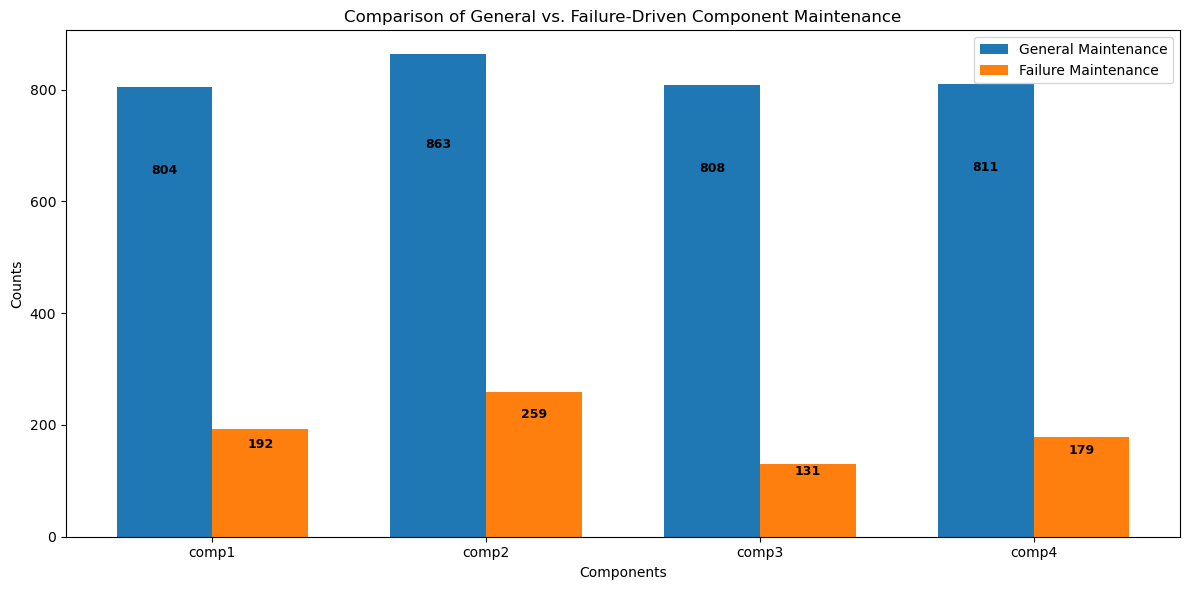

In [17]:
# Is a certain component more fragile/susceptible to maintenance? 

failure_dict = failures_raw['failure'].value_counts().to_dict()
maint_dict = maintenance_raw['comp'].value_counts().to_dict()

components = list(failure_dict.keys())
components.sort()
failure_counts = [failure_dict.get(comp) for comp in components]
maint_counts = [maint_dict.get(comp) for comp in components]

# Set positions for bars
x = np.arange(len(components))
width = 0.35  # width of the bars

# Plot bars side-by-side
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, maint_counts, width, label='General Maintenance')
bars2 = ax.bar(x + width/2, failure_counts, width, label='Failure Maintenance')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width()/2, 0.8*height),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labeling and titles
ax.set_xlabel('Components')
ax.set_ylabel('Counts')
ax.set_title('Comparison of General vs. Failure-Driven Component Maintenance')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

plt.tight_layout()
plt.show()

Most components are maintained at the same frequency in general. Interestingly, component 2 is the most replaced followed closely by component 1 when a failure occurs.

In [18]:
failure_error_maint = pd.concat([failures_raw, errors_raw, maintenance_raw])
print(failure_error_maint.shape[0] == errors_raw.shape[0] + maintenance_raw.shape[0] + failures_raw.shape[0], failure_error_maint.shape)
failure_error_maint.drop("time",axis=1,inplace=True)

True (7966, 6)


In [19]:
failure_error_maint.reset_index(inplace=True,drop=True)

In [20]:
failure_error_maint.head()

,datetime,machineID,failure,errorID,comp
0,2015-01-05 06:00:00,1,comp4,NaN,NaN
1,2015-03-06 06:00:00,1,comp1,NaN,NaN
2,2015-04-20 06:00:00,1,comp2,NaN,NaN
3,2015-06-19 06:00:00,1,comp4,NaN,NaN
4,2015-09-02 06:00:00,1,comp4,NaN,NaN


In [21]:
failure_error_maint[failure_error_maint['datetime'].duplicated() == True]

,datetime,machineID,failure,errorID,comp
8,2015-03-19 06:00:00,2,comp2,NaN,NaN
30,2015-01-24 06:00:00,7,comp4,NaN,NaN
60,2015-04-20 06:00:00,11,comp2,NaN,NaN
61,2015-04-20 06:00:00,11,comp3,NaN,NaN
63,2015-12-16 06:00:00,11,comp3,NaN,NaN
...,...,...,...,...,...
7961,2015-10-10 06:00:00,100,NaN,NaN,comp3
7962,2015-10-25 06:00:00,100,NaN,NaN,comp4
7963,2015-11-09 06:00:00,100,NaN,NaN,comp4
7964,2015-12-09 06:00:00,100,NaN,NaN,comp2


In [22]:
# Create a labelled dataframe including associated telemetry data for each failure and error

compiled_df = pd.merge(feature_df,failure_error_maint,on=["datetime","machineID"], how="left")
print(compiled_df.shape) # higher rows than feature_df because of multiple matching entries 
compiled_df.head()

(877878, 11)


,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,NaN,NaN,NaN


In [23]:
compiled_df.describe()

,machineID,volt,rotate,pressure,vibration,age
count,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000
mean,50.500001,170.784239,446.552883,100.864709,40.388412,11.331142
std,28.867029,15.513778,52.712569,11.055610,5.373539,5.827578
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,25.000000,160.308166,412.245488,93.500230,36.778872,7.000000
50%,50.000000,170.611766,447.524832,100.428426,40.239811,12.000000
75%,76.000000,181.012842,482.148314,107.560029,43.788410,16.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000


In [24]:
compiled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   877878 non-null  object 
 1   machineID  877878 non-null  int64  
 2   volt       877878 non-null  float64
 3   rotate     877878 non-null  float64
 4   pressure   877878 non-null  float64
 5   vibration  877878 non-null  float64
 6   model      877878 non-null  object 
 7   age        877878 non-null  int64  
 8   failure    761 non-null     object 
 9   errorID    3919 non-null    object 
 10  comp       2886 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 73.7+ MB


### Feature Engineering

In [25]:
# Convert object to datetime
compiled_df["datetime"] = pd.to_datetime(compiled_df["datetime"])

In [26]:
compiled_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,NaN,NaN,NaN


In [27]:
# compiled_df["failure"].fillna("No Failure", inplace=True)
# compiled_df["errorID"].fillna("No Error", inplace=True)
# compiled_df["comp"].fillna("No Maintenance", inplace=True)

In [28]:
compiled_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,NaN,NaN,NaN


In [29]:
data = pd.get_dummies(compiled_df, columns=["model"])

In [30]:
le = LabelEncoder()
data["errorID_label"] = le.fit_transform(data["errorID"])
data["comp_label"] = le.fit_transform(data["comp"])
data["failure_label"] = le.fit_transform(data["failure"])

In [31]:
data.head(5)

,datetime,machineID,volt,rotate,pressure,vibration,age,failure,errorID,comp,model_model1,model_model2,model_model3,model_model4,errorID_label,comp_label,failure_label
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,NaN,NaN,NaN,False,False,True,False,5,4,4
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,NaN,NaN,NaN,False,False,True,False,5,4,4
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,NaN,NaN,NaN,False,False,True,False,5,4,4
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,NaN,NaN,NaN,False,False,True,False,5,4,4
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,NaN,NaN,NaN,False,False,True,False,5,4,4


In [32]:
# The goal is to forecast telemetry values (volt, rotate, pressure, vibration) and predict errors (errorID) 24 hours in advance for each machineID

In [33]:
forecast_horizon = 24  # 24-hour forecast

# Create shifted forecast telemetry values - we are going back in time 
for col in ["volt", "rotate", "pressure", "vibration"]:
    data[f"{col}_future"] = data.groupby("machineID")[col].shift(-forecast_horizon)

# Forecast whether an error will occur (classification problem)
data["error_future"] = data.groupby("machineID")["errorID"].shift(-forecast_horizon).fillna("No Error")

In [34]:
# create lagged variables to capture trends / bhevaiour before failure
lag_hours = [1, 3, 6, 12, 24]

for col in ["volt", "rotate", "pressure", "vibration"]:
    for lag in lag_hours:
        data[f"{col}_lag_{lag}"] = data.groupby("machineID")[col].shift(lag)

In [35]:
window_sizes = [6, 12, 24]  # Short-term and long-term trends

for col in ["volt", "rotate", "pressure", "vibration"]:
    for window in window_sizes:
        data[f"{col}_rolling_mean_{window}"] = (
            data.groupby("machineID")[col]
            .rolling(window, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )
        data[f"{col}_rolling_std_{window}"] = (
            data.groupby("machineID")[col]
            .rolling(window, min_periods=1)
            .std()
            .reset_index(0, drop=True)
        )

In [36]:
data["hour"] = data["datetime"].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month
data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)

In [37]:
data.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,age,failure,errorID,comp,...,vibration_rolling_mean_6,vibration_rolling_std_6,vibration_rolling_mean_12,vibration_rolling_std_12,vibration_rolling_mean_24,vibration_rolling_std_24,hour,day_of_week,month,is_weekend
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,NaN,NaN,NaN,...,45.087686,NaN,45.087686,NaN,45.087686,NaN,6,3,1,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,NaN,NaN,NaN,...,44.250829,1.183494,44.250829,1.183494,44.250829,1.183494,7,3,1,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 70 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   datetime                   877878 non-null  datetime64[ns]
 1   machineID                  877878 non-null  int64         
 2   volt                       877878 non-null  float64       
 3   rotate                     877878 non-null  float64       
 4   pressure                   877878 non-null  float64       
 5   vibration                  877878 non-null  float64       
 6   age                        877878 non-null  int64         
 7   failure                    761 non-null     object        
 8   errorID                    3919 non-null    object        
 9   comp                       2886 non-null    object        
 10  model_model1               877878 non-null  bool          
 11  model_model2               877878 non-null  bool    

In [39]:
data.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,failure,errorID,comp,...,vibration_rolling_mean_6,vibration_rolling_std_6,vibration_rolling_mean_12,vibration_rolling_std_12,vibration_rolling_mean_24,vibration_rolling_std_24,hour,day_of_week,month,is_weekend
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,NaN,NaN,NaN,...,45.087686,NaN,45.087686,NaN,45.087686,NaN,6,3,1,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,NaN,NaN,NaN,...,44.250829,1.183494,44.250829,1.183494,44.250829,1.183494,7,3,1,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,NaN,NaN,NaN,...,40.893502,5.874970,40.893502,5.874970,40.893502,5.874970,8,3,1,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,NaN,NaN,NaN,...,40.950662,4.798255,40.950662,4.798255,40.950662,4.798255,9,3,1,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,NaN,NaN,NaN,...,37.958632,7.875828,37.958632,7.875828,37.958632,7.875828,10,3,1,0


In [40]:
# Ensure datetime format
data["datetime"] = pd.to_datetime(data["datetime"])

# Extract maintenance events
maint_events = data[["datetime", "machineID", "comp"]].dropna().copy()

# Forward-fill last maintenance timestamp within each machineID group
maint_events["last_maint_time"] = maint_events.groupby("machineID")["datetime"].transform("ffill")

# Merge back into the main dataset
data = data.merge(maint_events[["datetime", "machineID", "last_maint_time"]], on=["datetime", "machineID"], how="left")

# Forward-fill the last maintenance event for each machine
data["last_maint_time"] = data.groupby("machineID")["last_maint_time"].ffill()

# Compute time since last maintenance in hours
data["time_since_last_maint"] = (data["datetime"] - data["last_maint_time"]).dt.total_seconds() / 3600

# Fill NaNs (machines with no maintenance history)
data["time_since_last_maint"].fillna(9999, inplace=True)

# Drop temporary column
data.drop(columns=["last_maint_time"], inplace=True)


/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_51139/2457580055.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["time_since_last_maint"].fillna(9999, inplace=True)


In [41]:
# Extract errorenance events
error_events = data[["datetime", "machineID", "errorID"]].dropna().copy()

# Forward-fill last errorenance timestamp within each machineID group
error_events["last_error_time"] = error_events.groupby("machineID")["datetime"].transform("ffill")

# Merge back into the main dataset
data = data.merge(error_events[["datetime", "machineID", "last_error_time"]], on=["datetime", "machineID"], how="left")

# Forward-fill the last errorenance event for each machine
data["last_error_time"] = data.groupby("machineID")["last_error_time"].ffill()

# Compute time since last errorenance in hours
data["time_since_last_error"] = (data["datetime"] - data["last_error_time"]).dt.total_seconds() / 3600

# Fill NaNs (machines with no errorenance history)
data["time_since_last_error"].fillna(9999, inplace=True)

# Drop temporary column
data.drop(columns=["last_error_time"], inplace=True)

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_51139/3964952788.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["time_since_last_error"].fillna(9999, inplace=True)


In [42]:
data.drop(columns=["datetime", "failure"], inplace=True)

In [43]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [44]:
# !conda install xgboost

In [52]:
data['error_future']

0         No Error
1         No Error
2         No Error
3         No Error
4         No Error
            ...   
880371    No Error
880372    No Error
880373    No Error
880374    No Error
880375    No Error
Name: error_future, Length: 880376, dtype: object

In [50]:
from xgboost import XGBRegressor

features = data.drop(columns=["volt_future", "rotate_future", "pressure_future", "vibration_future", "error_future", "errorID", "comp", "failure_label"])
target = data["volt_future"]

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

XGBoostError: [02:04:30] /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/data/data.cc:461: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001498b59b4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x0000000149952f69 xgboost::MetaInfo::SetInfoFromHost(xgboost::GenericParameter const&, xgboost::StringView, xgboost::Json) + 4601
  [bt] (2) 3   libxgboost.dylib                    0x0000000149951c3f xgboost::MetaInfo::SetInfo(xgboost::GenericParameter const&, xgboost::StringView, xgboost::StringView) + 159
  [bt] (3) 4   libxgboost.dylib                    0x00000001498ccc19 XGDMatrixSetInfoFromInterface + 249
  [bt] (4) 5   libffi.8.dylib                      0x000000010bc88972 ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x0000000305cb95b0 0x0 + 12982130096



In [53]:
from xgboost import XGBClassifier

target_error = le.fit_transform(data["error_future"])

model_error = XGBClassifier(n_estimators=100, random_state=42)
model_error.fit(features, target_error)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(features)
print(f"MAE: {mean_absolute_error(target, y_pred)}")
print(f"RMSE: {mean_squared_error(target, y_pred, squared=False)}")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_error = model_error.predict(features)
precision, recall, f1, _ = precision_recall_fscore_support(target_error, y_pred_error, average='macro')

print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")


In [ ]:
# failure_error_maint['dt'] = failure_error_maint['datetime'].apply(lambda x: pd.to_datetime(x))

In [ ]:
# Check 1: Are there cases where multiple components failed at the same date and time?
# Check 2: Is it valid to then merge all mainte

In [163]:
error_dict = errors_raw['errorID'].value_counts().to_dict()
error_dict

{'error1': 1010, 'error2': 988, 'error3': 838, 'error4': 727, 'error5': 356}